In [10]:
import glob
import opencc
import copy
from IPython.display import display as print
from typing import List, Dict, Tuple, Optional,Union
from fontTools.ttLib import TTFont
from pathlib import Path
import cv2
from PIL import ImageFont, Image, ImageDraw
import textwrap
import glob
from tqdm.notebook import tqdm
import os
from neko_sdk.ocr_modules.charset.etc_cset import latin62 

def make_alphabet(text_file_list,dest_file_path):
    res_dict = {}
    res_set = set()
    converter = opencc.OpenCC('s2t.json');
    conv_t2s = opencc.OpenCC('t2s.json');
    upr="QWERTYUIOPASDFGHJKLZXCVBNM";
    lwr="qwertyuiopasdfghjklzxcvbnm";
    dig="1234567890";
    for t_path  in text_file_list:
        with open(t_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                a = line.split(" ")[0]
                b = conv_t2s.convert(a);
                for cid in range(len(b)):
                    k=b[cid];
                    v=a[cid];
                    if(k in latin62 or k in dig):
                        continue;
                    if(k not in res_dict):
                        res_dict[k]=set([k]);
                    res_dict[k].add(v);
    for i in range(26):
        res_dict[upr[i]]=set([upr[i],lwr[i]]);
    for i in range(10):
        res_dict[dig[i]]=set(dig[i]);
    
    with open(dest_file_path, 'w+') as f:
        for key, ele in res_dict.items():
            ele=ele.difference(set([key]));
            _x = key+" "+" ".join(list(ele))
            f.write(f"{_x}\n")

def make_alphabet_v2(text_file_list,dest_file_path):
    # 所有字符编程单列
    res_dict = {}
    upr="QWERTYUIOPASDFGHJKLZXCVBNM"
    all_str = upr + upr.lower()
    for cc in all_str:
        if cc not in res_dict:
            res_dict[cc] = 0
        res_dict[cc] += 1
    
    dig="1234567890"
    for cc in dig:
        if cc not in res_dict:
            res_dict[cc] = 0
        res_dict[cc] += 1
    
    for t_path  in text_file_list:
        with open(t_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                a = line.split(",")[0]
                for cc in a:
                    if cc not in res_dict:
                        res_dict[cc] = 0
                    res_dict[cc] += 1
    
    with open(dest_file_path, 'w+') as f:
        for c in upr:
            f.write(f"{c.upper()} {c.lower()}\n")
        
        for c, _ in res_dict.items():
            if c in all_str:
                continue
            f.write(f"{c}\n")
        
    return res_dict

def get_char_set(txt_f_paths):
    if not isinstance(txt_f_paths, list):
        txt_f_paths = [txt_f_paths]
    
    alphabets = set()
    for ffp in txt_f_paths:
        with open(ffp) as f:
            content = f.read()
        content = content.replace("\n","").replace(" ","")
        alphabets.update(list(content))
    return alphabets


def find_char_in_fonts(char, ttfonts: Union[List[TTFont], TTFont]):
    if not isinstance(ttfonts, list):
        ttfonts = [ttfonts]
    
    for ii, font in enumerate(ttfonts):
        ttFont = font['cmap'].tables[0].ttFont
        uniMap = ttFont.getBestCmap()
        ord_c = ord(char)
        hex_c = hex(ord_c)[2:]
        hex_c = str(hex_c).upper()
        if ord_c in uniMap.keys():
            return ii, font
    return None, None


def get_char_img_from_label(res_dict = None):
    # img_paths = glob.glob("./ddata/TKHMTH2200/*/img/*")
    if res_dict is None:
        res_dict = {}
    
    char_gt_paths = glob.glob("/home/izhangxm/Desktop/work/main/VSDF/ddata/TKHMTH2200/*/label_char/*.txt")
    char_gt_paths = char_gt_paths
    
    pbar = tqdm(total=len(char_gt_paths))
    
    for ii, char_gt_path in enumerate(char_gt_paths):
        char_gt_path = Path(char_gt_path)
        pbar.update(1)
        pbar.set_description(f'Processing:{ii+1}/{len(char_gt_paths)}')
        with open(char_gt_path, "r") as f:
            lines = f.readlines()
        
        read_img = False
        for line in lines:
            eles = line.replace("\n","").split(" ")
            if len(eles) != 5:
                continue
            char = eles[0]
            if char in res_dict:
                continue
            read_img = True
        
        if not read_img:
            continue
        
        try:
            img_path = char_gt_path.parent.parent/"img"/f"{char_gt_path.stem}.jpg"
            if not img_path.exists():
                img_path = char_gt_path.parent.parent/"img"/f"{char_gt_path.stem}.png"
            if not img_path.exists():
                raise Exception(f"not exist: {img_path}")
            img = cv2.imread(str(img_path))
        except Exception as e:
            print(e)
            continue
        
        try:
            for line in lines:
                eles = line.replace("\n","").split(" ")
                if len(eles) != 5:
                    continue
                char = eles[0]
                x1,y1,x2,y2 = [int(float(_)) for _ in eles[1:]]
                if char in res_dict:
                    continue
                char_img = img[y1:y2, x1:x2,:]
                char_img = cv2.resize(char_img, (64, 64), interpolation=cv2.INTER_LINEAR)
                
                res_dict[char] = char_img
        
        except Exception as e:
            print(char_gt_path)
            raise e
    
    return res_dict

import os
import regex
from osocr_tasks.tasksg1.dscs import makept_for_MTH

def make_dict(aplphabets_file_path, font_paths, dst_path, force_rebuild=False):
    if(os.path.exists(dst_path)) and (not force_rebuild):
        print("skipping pt build, to force rebuilding, remove", dst_path);
        return dst_path;
    with open(aplphabets_file_path, 'r') as fp:
        chars=[l.strip() for l in fp];
        allch=[];
        masters=[];
        servants=[];
        for ch in chars:
            if(len(ch)):
                l= regex.findall(r'\X', ch, regex.U);
                allch+=l;
                for i in range(1,len(l)):
                    masters.append(l[0]);
                    servants.append(l[i]);
    allch=set(allch)
    makept_for_MTH(None,font_paths,dst_path,allch, {}, masters=masters, servants=servants);
    return dst_path

from neko_sdk.lmdb_wrappers.im_lmdb_wrapper import ImLmdbWrapper
import glob
import os.path
import cv2
from pathlib import Path

def cal_bounding_box(ps):
    # 左下角，顺时针转圈, 返回左上角+右下角的信息
    x1,y1,x2,y2,x3,y3,x4,y4 =  ps
    _x1 = min(x1,x2,x3,x4)
    _y1 = min(y1,y2,y3,y4)
    _x2 = max(x1,x2,x3,x4)
    _y2 = max(y1,y2,y3,y4)
    return _x1,_y1,_x2,_y2

def quick_lmdb_for_mth(gt_file_path_list, dst,lang="None"):
    mth_dataset_dir = str(Path(gt_file_path_list[0]).parent.parent)
    img_dir = Path(os.path.join(mth_dataset_dir,"img"))
    if os.path.exists(f"{dst}/data.mdb"):
        os.remove(f"{dst}/data.mdb")
    if os.path.exists(f"{dst}/lock.mdb"):
        os.remove(f"{dst}/lock.mdb")
    
    db=ImLmdbWrapper(dst)

    for ii, char_file in enumerate(gt_file_path_list):
        char_file = Path(char_file)
        img_file_path = img_dir/ f"{char_file.stem}.png"
        
        if not img_file_path.exists():
            img_file_path = img_dir/ f"{char_file.stem}.jpg"
        
        if not img_file_path.exists():
            continue
            
        img_full = cv2.imread(str(img_file_path))
        if ii % 500 == 0:
            print(f"{ii+1}/{len(gt_file_path_list)} {char_file}")
        try:
            f = open(char_file, 'r')
            lines = f.readlines()
            for line in lines:
                eles = line.replace("\n", "").split(',')
                anno = eles[0]
                ps = [int(_) for _ in eles[1:]]
                x1,y1,x2,y2 = cal_bounding_box(ps)
                img = img_full[y1:y2, x1:x2,:]
                db.add_data_utf(img,anno,lang)
        except Exception as e:
            print(e, line)
            print(img_file_path)
        finally:
            f.close()
    db.end_this()
def split_res_dict_for_matplot(db_alphabet_res_dict: dict):
    X = []
    Y = []
    for c, n  in db_alphabet_res_dict.items():
        X.append(c)
        Y.append(n)
    return X, Y
db_names = ["MTH1000", "MTH1200", "TKH"]


In [2]:

for db_name in db_names:
    # _rr = make_alphabet_v2(glob.glob(f"ddata/TKHMTH2200/{db_name}/label_textline/*.txt"),f"runtime/alphabet_{db_name}_ssss.txt")
    pass

In [6]:
import random
import pickle

train_ratio = 0.75
font_paths = glob.glob("ddata/fonts/HanaMin/**/*.ttf", recursive=True)
res_apl = {}
res_apl_path = "runtime/res_apl.pt"

for db_name in db_names:
    db_info = {}

    text_file_list = glob.glob(f"ddata/TKHMTH2200/{db_name}/label_textline/*.txt")
    random.shuffle(text_file_list)

    train_n = int(len(text_file_list) * train_ratio)
    train_list = text_file_list[:train_n]
    test_all_list = text_file_list[train_n:]
    db_info['train_list'] = train_list
    db_info['test_all_list'] = test_all_list

    train_alphabet = f"ddata/recdatassd/{db_name}/alphabet_{db_name}_train.txt"
    _rr = make_alphabet_v2(train_list, train_alphabet)
    db_info['train_alpha'] = _rr

    test_all_alphabet = f"ddata/recdatassd/{db_name}/alphabet_{db_name}_test_all.txt"
    _rr = make_alphabet_v2(test_all_list, test_all_alphabet)
    db_info['test_all_alpha'] = _rr

    # make_dict(train_alphabet, font_paths, f"ddata/recdatassd/{db_name}/dict_train.pt", force_rebuild=True)
    res_apl[db_name] = db_info

import torch
torch.save(res_apl, res_apl_path)

# pickle.dump(res_apl, open(res_apl_path, 'w+'))


In [7]:
if os.path.exists(res_apl_path):
    res_apl = torch.load(res_apl_path)

In [11]:
# 创建lmdb
for db_name, db_info in res_apl.items():
    gt_file_path_list = db_info['train_list']
    dst = f"ddata/recdatassd/{db_name}_train"
    quick_lmdb_for_mth(gt_file_path_list, dst,lang="None")
    
    gt_file_path_list = db_info['test_all_list']
    dst = f"ddata/recdatassd/{db_name}_test_all"
    quick_lmdb_for_mth(gt_file_path_list, dst,lang="None")
    


'501/900 ddata/TKHMTH2200/MTH1200/label_textline/YB_28_500.txt'

'1/300 ddata/TKHMTH2200/MTH1200/label_textline/YB_30_159.txt'

'1/749 ddata/TKHMTH2200/TKH/label_textline/0001_034_26_09.txt'

'501/749 ddata/TKHMTH2200/TKH/label_textline/0001_025_26_14.txt'

'1/250 ddata/TKHMTH2200/TKH/label_textline/0001_029_27_01.txt'

In [13]:
for db_name, db_info in res_apl.items():
    _alphabet = f"ddata/recdatassd/{db_name}_train/alphabet_{db_name}_train.txt"
    make_dict(_alphabet, font_paths, f"ddata/recdatassd/{db_name}_train/dict_train.pt", force_rebuild=False)
    
    _alphabet = f"ddata/recdatassd/{db_name}_test_all/alphabet_{db_name}_test_all.txt"
    make_dict(_alphabet, font_paths, f"ddata/recdatassd/{db_name}_test_all/dict_test_all.pt", force_rebuild=False)


0 of 5025
500 of 5025
1000 of 5025
1500 of 5025
found space
 
2000 of 5025
2500 of 5025
3000 of 5025
3500 of 5025
4000 of 5025
4500 of 5025
5000 of 5025
0 of 3313
500 of 3313
1000 of 3313
1500 of 3313
2000 of 3313
found space
 
2500 of 3313
3000 of 3313
0 of 4969
500 of 4969
1000 of 4969
1500 of 4969
found space
 
2000 of 4969
2500 of 4969
3000 of 4969
3500 of 4969
4000 of 4969
4500 of 4969
0 of 3582
500 of 3582
1000 of 3582
1500 of 3582
2000 of 3582
2500 of 3582
found space
 
3000 of 3582
3500 of 3582
0 of 1343
500 of 1343
found space
 
1000 of 1343
0 of 1087
500 of 1087
found space
 
1000 of 1087


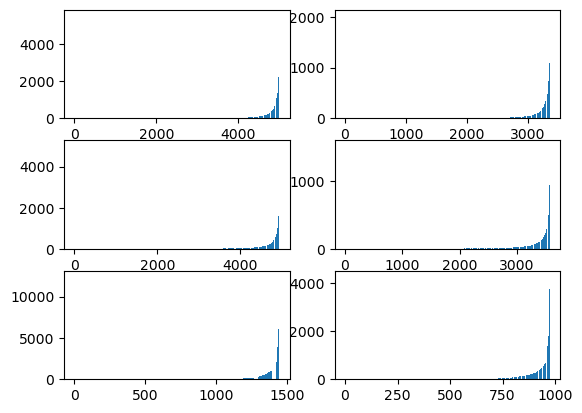

In [36]:
from matplotlib import plot as plt

fig, axes = plt.subplots(3, 2)
axes = axes.reshape(-1)
i = 0
for db_name, db_info in res_apl.items():
    keyss = ["train_alpha", "test_all_alpha"]
    for key in keyss:
        _alpha = db_info[key]
        X, Y = split_res_dict_for_matplot(_alpha)
        axes[i].bar(range(len(Y)), sorted(Y))
        i+=1
# plt.bar(range(len(Y)), sorted(Y))

In [ ]:
res_dict = get_char_img_from_label()
# aa  = 0
# for char,char_img in res_dict.items():
#     print(char)
#     char_img = cv2.resize(char_img, (64, 64), interpolation=cv2.INTER_LINEAR)
#     print(Image.fromarray(char_img))
#     aa += 1
#     if aa>5:
#         break

In [ ]:

# txt
alphabets = list(res_dict.keys())
alphabets = sorted(alphabets)

text = "".join(alphabets)

# fonts
font_path_list = glob.glob("ddata/fonts/HanaMin/**/*.ttf", recursive=True)

fontSize = 64
ttfonts,imFonts = [],[]
for f_p in font_path_list:
    ttfonts.append( TTFont(f_p))
    imFonts.append(ImageFont.truetype(f_p, size=fontSize))

# font_family = ImageFont.truetype_family(*imFonts)

char_font_ids = []
for char in alphabets:
    ii, _ = find_char_in_fonts(char, ttfonts=ttfonts)
    char_font_ids.append(ii)

fontSize = 64
max_len = 32
lines = textwrap.wrap(text, width=max_len)

FOREGROUND = "#000000"
bground = (255,255,255)

im_font = imFonts[0]
tw, th = im_font.getsize(char)
im = Image.new("RGB", ((fontSize * max_len), 2 * len(lines) * (fontSize + 8)), (255, 255, 255))
dr = ImageDraw.Draw(im)

miss_char = []
x,y=0,0
for i,char,f_id in zip(range(len(alphabets)), alphabets, char_font_ids):
    if f_id is None:
        col = i % max_len
        row = int(i/max_len)
        miss_char.append(f"{row+1},{col}, {char}")
        f_id = 0
    im_font = imFonts[f_id]
    char_img = res_dict[char]
    
    x = tw * (i % max_len)
    y = 2 * th * int(i/max_len)
    
    dr.text((x, y), char, font=im_font, fill=FOREGROUND, spacing=0, align="left")
    char_img = cv2.resize(char_img, (64, 64), interpolation=cv2.INTER_LINEAR)
    char_img = Image.fromarray(char_img)
    im.paste(char_img,(x,y+th))

print(miss_char)
# print(im)
im.save("runtime/alphabets-char-3.jpg")


/tmp/ipykernel_1452547/2076257061.py:31: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  tw, th = im_font.getsize(char)


['198,31, \ue360']

In [ ]:
font_paths = glob.glob("ddata/fonts/HanaMin/**/*.ttf", recursive=True)

# --------------------------------------------------------------
# db_names = ["MTH1000","MTH1200", "TKH"]
# for db_name in db_names:
#     aplphabets_file_path = f"runtime/alphabet_{db_name}.txt"
#     dst_path = f"ddata/MTH_DB/{db_name}/dict.pt"
#     make_dict(aplphabets_file_path, font_paths, dst_path, force_rebuild=True)

# --------------------------------------------------------------
db_names = ["MTH1000", "MTH1200", "TKH"]
for db_name in db_names:
    make_dict(f"ddata/recdatassd/{db_name}/alphabet_{db_name}.txt", font_paths, f"ddata/recdatassd/{db_name}/dict.pt", force_rebuild=True)


In [ ]:
from PIL import ImageFont, Image, ImageDraw
import textwrap
import glob
def render_char():
    # txt
    alphbats_file_list = glob.glob("ddata/quickviet/alphabet_*.txt")
    alphabets = get_char_set(alphbats_file_list)
    alphabets = list(alphabets)
    text = "".join(alphabets)

    # fonts
    font_path_list = glob.glob("ddata/fonts/HanaMin/**/*.ttf", recursive=True)

    fontSize = 64
    ttfonts,imFonts = [],[]
    for f_p in font_path_list:
        ttfonts.append( TTFont(f_p))
        imFonts.append(ImageFont.truetype(f_p, size=fontSize))

    font_family = ImageFont.truetype_family(*imFonts)

    char_font_ids = []
    for char in alphabets:
        ii, _ = find_char_in_fonts(char, ttfonts=ttfonts)
        char_font_ids.append(ii)

    fontSize = 64
    max_len = 32
    lines = textwrap.wrap(text, width=max_len)

    FOREGROUND = "#000000"
    bground = (255,255,255)

    im_font = imFonts[0]
    tw, th = im_font.getsize(char)
    im = Image.new("RGB", ((fontSize * max_len), len(lines) * (fontSize + 8)), (255, 255, 255))
    dr = ImageDraw.Draw(im)

    miss_char = []
    x,y=0,0
    for i,char,f_id in zip(range(len(alphabets)), alphabets, char_font_ids):
        if f_id is None:
            col = i % max_len
            row = int(i/max_len)
            miss_char.append(f"{row+1},{col}, {char}")
            f_id = 0
        im_font = imFonts[f_id]

        x = tw * (i % max_len)
        y = th * int(i/max_len)
        
        dr.text((x, y), char, font=im_font, fill=FOREGROUND, spacing=0, align="left")
        
    print(miss_char)
    im.save("runtime/alphabets2.jpg")

# render_char()

In [ ]:
# mth_dataset_dir = "/home/izhangxm/Desktop/work/main/VSDF/ddata/TKHMTH2200/MTH1200"
# dst = "/home/izhangxm/Desktop/work/main/VSDF/ddata/lmdb/MTH1200"
# quick_lmdb(mth_dataset_dir, dst)

# mth_dataset_dir = "/home/izhangxm/Desktop/work/main/VSDF/ddata/TKHMTH2200/MTH1000"
# dst = "/home/izhangxm/Desktop/work/main/VSDF/ddata/lmdb/MTH1000"
# quick_lmdb(mth_dataset_dir, dst)

# mth_dataset_dir = "/home/izhangxm/Desktop/work/main/VSDF/ddata/TKHMTH2200/TKH"
# dst = "/home/izhangxm/Desktop/work/main/VSDF/ddata/lmdb/TKH"
# quick_lmdb(mth_dataset_dir, dst)

In [ ]:
import cv2

def line_image_test():
    img_path = "/home/izhangxm/Desktop/work/main/VSDF/ddata/TKHMTH2200/MTH1200/img/GL_8_5_10.jpg"
    img_full = cv2.imread(img_path)
    line = "四法世閒沙門婆羅門及長壽天心,5475,3308,5475,791,5682,791,5682,3308\n"
    eles = line.replace("\n", "").split(',')
    anno = eles[0]
    ps = [int(_) for _ in eles[1:]]
    x1,y1,x2,y2 = cal_bounding_box(ps)
    img = img_full[y1:y2, x1:x2,:]
    cv2.imwrite("runtime/a.jpg", img)
# line_image_test()

In [ ]:
import lmdb
db_path = "ddata/MTH_DB/MTH1200"
env = lmdb.open(db_path)
with env.begin(write=False) as txn:
    length = txn.stat()['entries']
    print(length)
    keys = list(txn.cursor().iternext(values=False))
    print(len(keys))
env.close()

132454

132454

In [ ]:
import glob

def eval_fonts():
    alphbats_file_list = glob.glob("ddata/quickviet/alphabet_*.txt")
    alphabets = get_char_set(alphbats_file_list)

    font_path_list = glob.glob("ddata/fonts/HanaMin/**/*.ttf", recursive=True)
    char_in_unimap = set()
    miss_char = copy.deepcopy(alphabets)

    for f_p in font_path_list:
        font = TTFont(f_p)
        ttFont = font['cmap'].tables[0].ttFont
        uniMap = ttFont.getBestCmap()
        glyfMapDict = font['glyf']
        
        _new_miss = []
        for c in miss_char:
            ord_c = ord(c)
            hex_c = hex(ord_c)[2:]
            hex_c = str(hex_c).upper()
            if (f"u{hex_c}" in glyfMapDict) or (f"uni{hex_c}" in glyfMapDict):
                if c in char_in_unimap:
                    char_in_unimap.remove(c)
                continue
            
            if ord_c in uniMap.keys():
                char_in_unimap.add(c)
            
            _new_miss.append(c)
            
            # 方法1 总计6631 检测出331个缺失
            # try:
            #     ttFont.getGlyphID(f"uni{str(hex_c).upper()}")
            # except Exception:
            #     _new_miss.append(c)
            #     continue
            # 方法2 总计6631 检测出3个缺失
            # if ord_c not in uniMap.keys():
            #     _new_miss.append(c)
            #     continue
        miss_char = _new_miss

    print(f"miss: {len(miss_char)} total:{len(alphabets)}")
    # print([f"char:{_}, ucode:{hex(ord(_))}" for _ in miss_char])
    print(f"cha not in glyph({len(miss_char)}): {miss_char}")
    print(f"cha not in glyph but in uniMap({len(char_in_unimap)}): {char_in_unimap}")
    print(f"miss: {set(miss_char) - char_in_unimap}")
    # print(hex(ord("嗢")))

eval_fonts()


In [ ]:
import torch
import pickle
import numpy as np


images_t = torch.load("runtime/batch_images4.pt")

aa = images_t.numpy()
print(aa.shape)

from PIL import Image
for i in range(10):
    img = Image.fromarray((aa[i] * 255).astype(np.uint8).transpose(1, 2, 0) )
    print(img)
    # print((aa[0] * 255).astype(np.uint8).shape)
